# Some analysis on my ~7500 Reddit comments


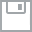
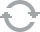
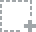
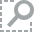
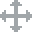
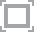
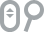
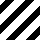
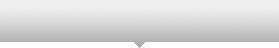
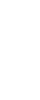
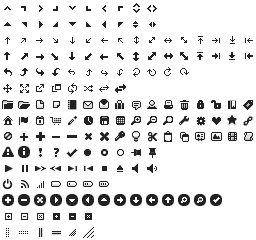
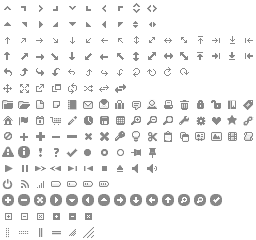
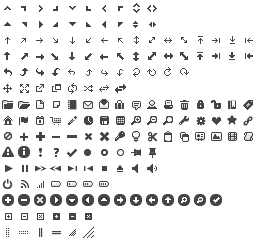
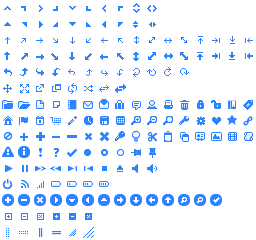
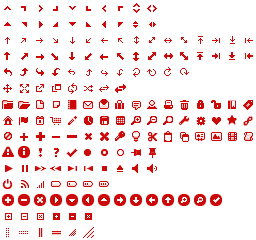
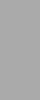
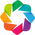
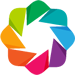

In [91]:
%matplotlib inline
import json
import pandas as pd
from bokeh.plotting import figure, output_notebook, show
from bokeh.models.ranges import FactorRange
import matplotlib.pyplot as plt
output_notebook()

Firstly, we want to define a function that will grab all of our comment data and convert it to dictionaries from JSON.

In [2]:
def parse_comment_file():
    """
    Parse each comment in the JSON file into a dict and then add it to a list, then return the list
    """
    # Empty list for storage
    comment_list = []

    # Open the file
    with open('nikskoCommentsToAugust2015.json', 'r') as file:
        # For every line
        for line in file:
            # Parse the line into a dict
            comment_dict = json.loads(line)
            # Put the dict on the end of the list
            comment_list.append(comment_dict)

    return comment_list

Now we can do some analysis. Firstly, we'll look at comment frequency, both by day and by month.

In [3]:
# Parse the file
comment_list = parse_comment_file()

# Sort the list based on the UTC time
comment_list.sort(key=lambda x: x['created_utc'])

# Throw this into a pandas dataframe
comment_frame = pd.DataFrame(comment_list)

# Fix the datatypes on the columns
comment_frame[['created_utc', 'score']] = comment_frame[['created_utc', 'score']].astype(int)
comment_frame[['subreddit', 'body']] = comment_frame[['subreddit', 'body']].astype(str)

# Convert from unix UTC dates to local times
comment_frame['created_local'] = pd.to_datetime(comment_frame['created_utc'], unit='s')

# Set the created_local as the index
comment_frame = comment_frame.set_index('created_local')

Before we do any plotting, let's make the figures look a little nicer

In [71]:
# Resample daily and count
daily_frame = comment_frame.resample('D', how='count')
# Reset the index for plotting
daily_frame.reset_index(inplace=True)
# Remove and rename some columns
daily_frame = daily_frame.drop(['score', 'created_utc','subreddit'], 1)
daily_frame.columns = ['date', 'count']
daily_frame['rolling_mean'] = pd.rolling_mean(daily_frame['count'], 30, 0)

# Create the figure
p = figure(width=950, height=400, x_axis_type="datetime")
p.line(daily_frame['date'], daily_frame['count'], color='lightgrey', alpha=0.5)
p.line(daily_frame['date'], daily_frame['rolling_mean'], color='blue')
p.xgrid.grid_line_color = None
p.xgrid[0].ticker.desired_num_ticks = 8
p.ygrid.grid_line_dash = [2, 2]
p.ygrid.grid_line_alpha = 0.5
print(p.title_text_font_size)
p.title = 'Daily comment frequency 2008-2015'
show(p)

12pt


Next we'll look at comment breakdown by subreddit.

In [88]:
NUM_RESULTS = 20

# Count comments by subreddit
subreddit_frame = comment_frame.groupby('subreddit').count()

# Drop unneeded columns
subreddit_frame = subreddit_frame.drop(['created_utc', 'score'], 1)
subreddit_frame['count'] = subreddit_frame['body']
subreddit_frame = subreddit_frame.drop('body', 1)

# Sort based on count, descending
subreddit_frame = subreddit_frame.sort('count', ascending=False)

# Grab the top 20 entries and put them into a new frame
bar_frame = subreddit_frame.head(NUM_RESULTS)

# Aggregate the remaining entries and add them as an other entry
other_count = int(subreddit_frame.iloc[NUM_RESULTS:].sum())

# Add the other category
bar_frame = bar_frame.append(pd.DataFrame({'count':other_count}, index=['other']))

# Reset the index for plotting
bar_frame.reset_index(inplace=True)
print(bar_frame)
p = Bar(bar_frame, label='subreddit', values='count', xlabel="", ylabel="", color='lightblue')
p.title = "Total comment breakdown by subreddit"
p.x_range = FactorRange(factors=bar_frame['subreddit'].tolist())
show(p)

            subreddit  count
0             Android   2150
1         Homebrewing    590
2           melbourne    512
3                beer    441
4             AusBeer    387
5         photography    316
6   malefashionadvice    287
7           australia    240
8           Minecraft    197
9          technology    137
10            Cooking    135
11               food    130
12             Coffee    118
13         3Dprinting    111
14               IAmA    107
15               math     92
16          worldnews     79
17      todayilearned     72
18             gaming     68
19     TheoryOfReddit     63
20              other   1294


/usr/lib/python3.5/site-packages/ipykernel/__main__.py:12: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/usr/lib/python3.5/site-packages/bokeh/charts/_attributes.py:78: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  df = df.sort(columns=columns)


Next we'll do some word frequency analysis

In [89]:
# Import a few things we need
from wordcloud import WordCloud

/usr/lib/python3.5/site-packages/PIL/ImageDraw.py:104: UserWarning: setfont() is deprecated. Please set the attribute directly instead.
  "Please set the attribute directly instead.")


(-0.5, 1599.5, 899.5, -0.5)

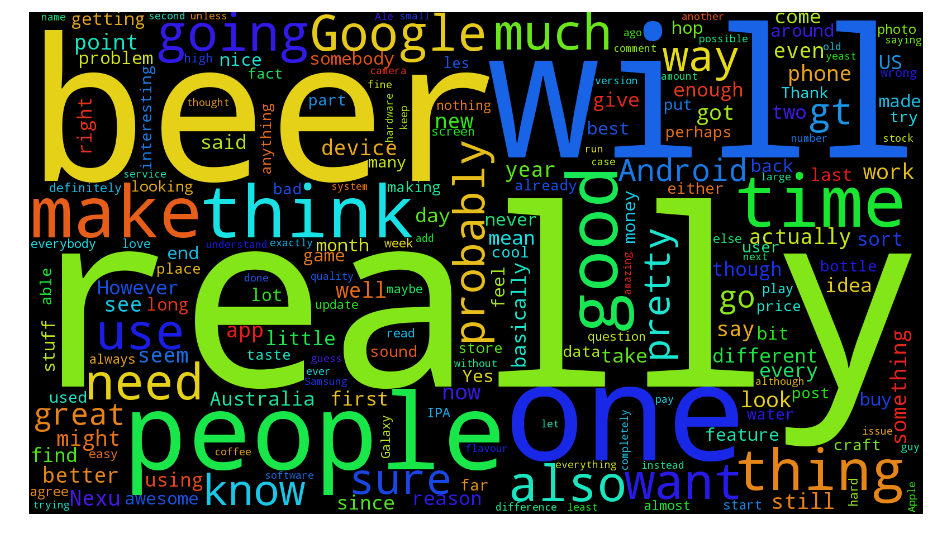

In [92]:
# Join all of the comments by spaces. Then split them. Then Count them
text = " ".join(comment_frame['body'])
# Generate the wordcloud
wordcloud = WordCloud(width=1600, height=900).generate(text)
# Show the image
plt.figure(figsize=(16,9))
plt.imshow(wordcloud)
plt.axis("off")